In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

In [2]:
from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries

from diffSPH.v2.sampling import sampleRegular
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import mod, volumeToSupport
from diffSPH.kernels import getKernel
from diffSPH.v2.neighborhood import neighborSearch
from diffSPH.v2.sampling import samplePDF
import numpy as np
import torch


In [3]:
from diffSPH.v2.finiteDifference import computeGradient
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

def plotSDF(fx, X, Y, extent, dim, ngrid = 255):
    fig, axis = plt.subplots(1, 3, figsize=(14,4), sharex = False, sharey = False, squeeze = False)

    fx = fx.reshape(ngrid, ngrid)
    output = computeGradient(fx, extent, dim, 1)
    # Plot the isocontours of fx
    axis[0,0].contour(X.numpy(), Y.numpy(), fx.numpy(), levels=[0], colors='black')


    # sdfValues = sdCircle(P, 1.0)
    # sdfGradient = gradient(sdfValues, 4, 1, 2)
    # sdfGradient = torch.stack([centralDifference(sdfValues, 1/ngrid, 1, 4), centralDifference(sdfValues, 1/ngrid, 1, 4)], axis=-1)
    # sdfValues = fx
    # sdfGradient = output
    # print(sdfGradient.shape)

    im = axis[0,0].pcolormesh(X.numpy(), Y.numpy(), fx.numpy(), cmap='Spectral',vmin = - torch.max(torch.abs(fx)).numpy(), vmax = torch.max(torch.abs(fx)).numpy())
    axis[0,0].set_title("SDF")
    axis[0,0].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    spacing = 16
    axis[0,0].quiver(X[::spacing,::spacing].numpy(), Y[::spacing,::spacing].numpy(), output[::spacing,::spacing,0].numpy(), output[::spacing,::spacing,1].numpy())

    im = axis[0,1].pcolormesh(X.numpy(), Y.numpy(), output[:,:,0].numpy(), cmap='viridis')
    axis[0,1].set_title("SDF Gradient X")
    axis[0,1].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axis[0,2].pcolormesh(X.numpy(), Y.numpy(), output[:,:,1].numpy(), cmap='viridis')
    axis[0,2].set_title("SDF Gradient Y")
    axis[0,2].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    # im = axis[0,3].imshow(torch.linalg.norm(output[:,:], dim = -1), extent=(-2, 2, -2, 2), origin='lower', cmap='inferno')
    # axis[0,3].set_title("SDF Gradient Magnitude")
    # divider = make_axes_locatable(axis[0,3])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im, cax=cax, orientation='vertical')
    # axis[0,3].set_title("SDF Gradient")
    # axis[0,3].set_aspect('equal', 'box')
    # axis[0,3].set_xlim(-2, 2)
    # axis[0,3].set_ylim(-2, 2)

    fig.tight_layout()

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None):
    sc = axis.scatter(p[:,0], p[:,1], s = 8, c = c)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(-1.05,1.05)
    axis.set_ylim(-1.05,1.05)

# 2D Plot

In [4]:
minExtent = -1
maxExtent = 1
nx = 64
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True
dim = 2
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

p, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h


i, j, rij, xij, hij, Wij, gradWij = neighborSearch(p, p, h, h, kernel = k, dim = dim, periodic = True, minDomain = domainMin, maxDomain = domainMax)
ii, ni = countUniqueEntries(i, p)


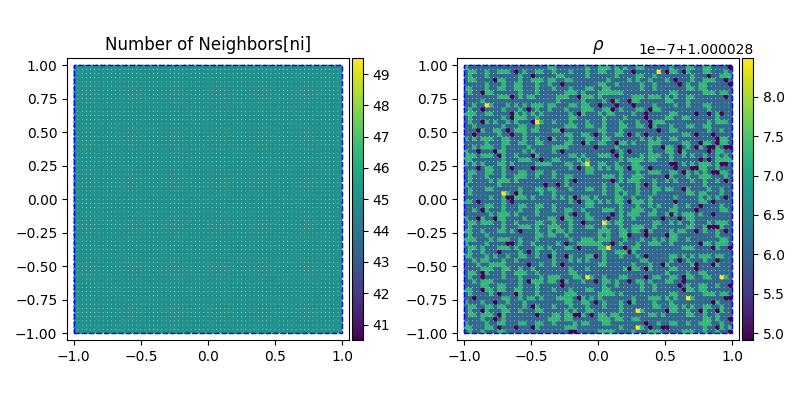

In [5]:
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)


scatterPlot(fig, axis[0,0], p, ni, domainMin, domainMax, 'Number of Neighbors[ni]')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')

scatterPlot(fig, axis[0,1], p, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

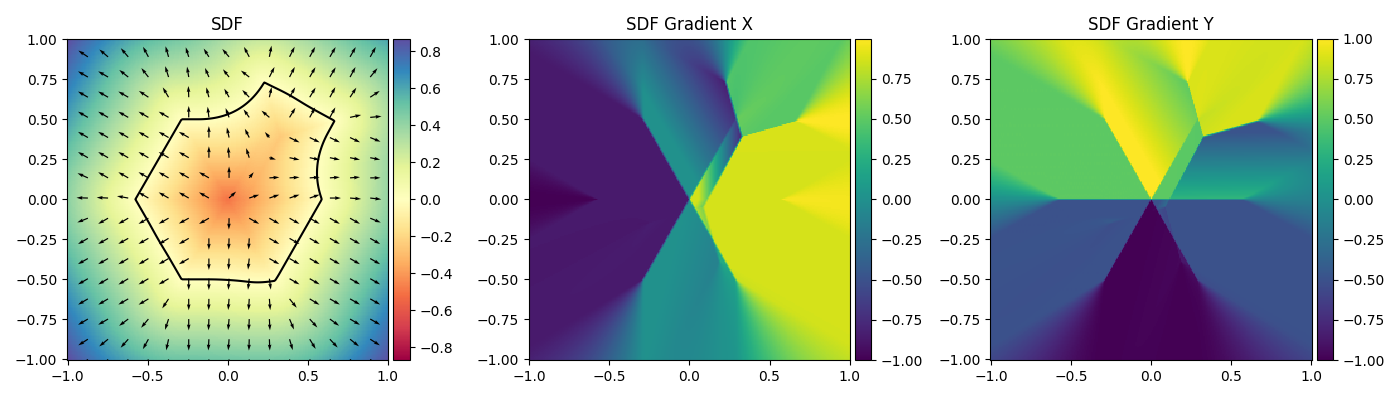

In [86]:


ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [7]:
# fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

# sdf_i = sdf(p)


# scatterPlot(fig, axis[0,0], p, sdf_i, domainMin, domainMax, 'Signed Distance Values')
# scatterPlot(fig, axis[0,1], p, sdf_i < 0, domainMin, domainMax, 'SDF Mask')

# fig.tight_layout()

In [8]:
from diffSPH.v2.sampling import filterParticlesWithSDF
from diffSPH.v2.finiteDifference import centralDifferenceStencil, continuousGradient


stencil = centralDifferenceStencil(1, 2)

sdfGradient = continuousGradient(sdf, p, stencil, 0.2 * h, 1)
sdfGradient = torch.nn.functional.normalize(sdfGradient, dim = -1)

# fig, axis = plt.subplots(1, 4, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
# scatterPlot(fig, axis[0,0], p, sdf_i, domainMin, domainMax, 'Signed Distance Values')
# scatterPlot(fig, axis[0,1], p, sdf_i < 0, domainMin, domainMax, 'SDF Mask')
# scatterPlot(fig, axis[0,2], p, sdfGradient[:,0], domainMin, domainMax, 'SDF Gradient X')
# scatterPlot(fig, axis[0,3], p, sdfGradient[:,1], domainMin, domainMax, 'SDF Gradient Y')


In [9]:
masked, mask, maskedSDF, maskedSDFGradient = filterParticlesWithSDF(p, sdf, h, 0.0)

# fig, axis = plt.subplots(1, 4, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
# scatterPlot(fig, axis[0,0], masked, maskedSDF, domainMin, domainMax, 'Signed Distance Values')
# scatterPlot(fig, axis[0,1], masked, maskedSDF < 0, domainMin, domainMax, 'SDF Mask')
# scatterPlot(fig, axis[0,2], masked, maskedSDFGradient[:,0], domainMin, domainMax, 'SDF Gradient X')
# scatterPlot(fig, axis[0,3], masked, maskedSDFGradient[:,1], domainMin, domainMax, 'SDF Gradient Y')

# fig.tight_layout()

In [10]:
from diffSPH.v2.sdf import operatorDict

In [11]:
particlesA, volumeA = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)
areasA = particlesA.new_ones(particlesA.shape[0]) * volumeA
onesA = particlesA.new_ones(particlesA.shape[0])
supportsA = particlesA.new_ones(particlesA.shape[0]) * h

factor = 1
particlesB, volumeB = sampleRegular(dx / factor, dim, minExtent, domainMax, targetNeighbors, True, k)
hB = volumeToSupport(volumeB, targetNeighbors, dim)
areasB = particlesB.new_ones(particlesB.shape[0]) * volumeA
onesB = particlesB.new_ones(particlesB.shape[0])
supportsB = particlesB.new_ones(particlesB.shape[0]) * h

maskedA, maskA, *_ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), h, -1e-4)
maskedB, maskB, *_ = filterParticlesWithSDF(particlesB, sdf, h, 0)

particles = torch.cat([maskedA, maskedB], dim = 0)
areas = torch.cat([areasA[maskA], areasB[maskB]], dim = 0)
ones = torch.cat([onesA[maskA], onesB[maskB]], dim = 0)
supports = torch.cat([supportsA[maskA], supportsB[maskB]], dim = 0)

print(particles.shape, areas.shape, ones.shape, supports.shape)
print(particlesA.shape, areasA.shape, onesA.shape, supportsA.shape)
print(particlesB.shape, areasB.shape, onesB.shape, supportsB.shape)
print(maskedA.shape, maskedB.shape)



i, j, rij, xij, hij, Wij, gradWij = neighborSearch(particles, particles, supports, supports, kernel = k, dim = dim, periodic = True, minDomain = domainMin, maxDomain = domainMax)
ii, ni = countUniqueEntries(i, particles)

torch.Size([4096, 2]) torch.Size([4096]) torch.Size([4096]) torch.Size([4096])
torch.Size([4096, 2]) torch.Size([4096]) torch.Size([4096]) torch.Size([4096])
torch.Size([4096, 2]) torch.Size([4096]) torch.Size([4096]) torch.Size([4096])
torch.Size([2490, 2]) torch.Size([1606, 2])


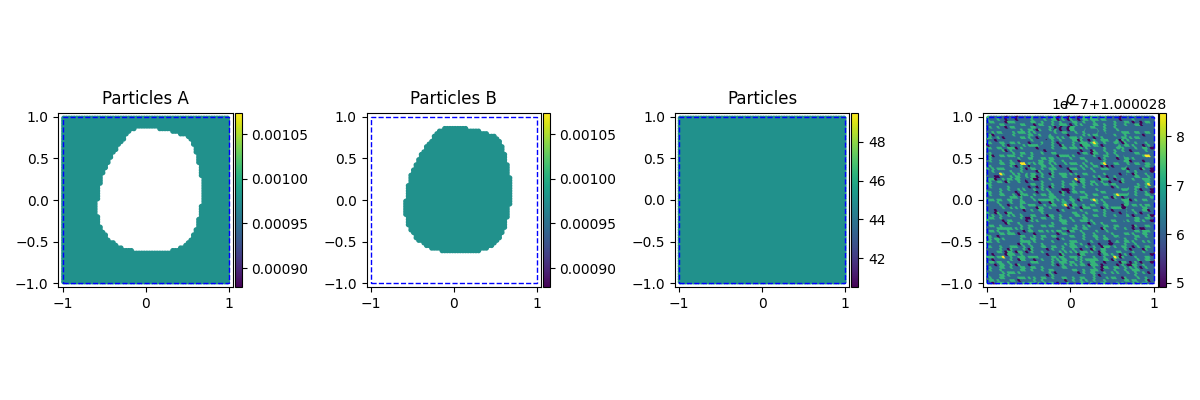

In [12]:

fig, axis = plt.subplots(1, 4, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], maskedA, areasA[maskA], domainMin, domainMax, 'Particles A')
scatterPlot(fig, axis[0,1], maskedB, areasB[maskB], domainMin, domainMax, 'Particles B')
scatterPlot(fig, axis[0,2], particles, ni, domainMin, domainMax, 'Particles')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, particles.shape[0], operation = 'interpolate')
scatterPlot(fig, axis[0,3], particles, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

# No support for dimensions other than 2

In [13]:


ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('circle')['function'](points, 1.0)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.15)
sdf = operatorDict['blend'](rotated, sphere_a, 0.5)

sdf = lambda points: getSDF('hexagon')['function'](points, 0.5)
# sdf = lambda points: getSDF('box')['function'](points, torch.tensor([0.5,0.5]))
# plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [18]:
from diffSPH.v2.sampling import sampleSDFWithParticles, sampleSDF, find_contour, contourLength, adjustSpacing, sampleContour

In [19]:
sampled, *_ = sampleSDFWithParticles(sdf, minExtent, maxExtent, nGrid, dx, 3, 3)

5


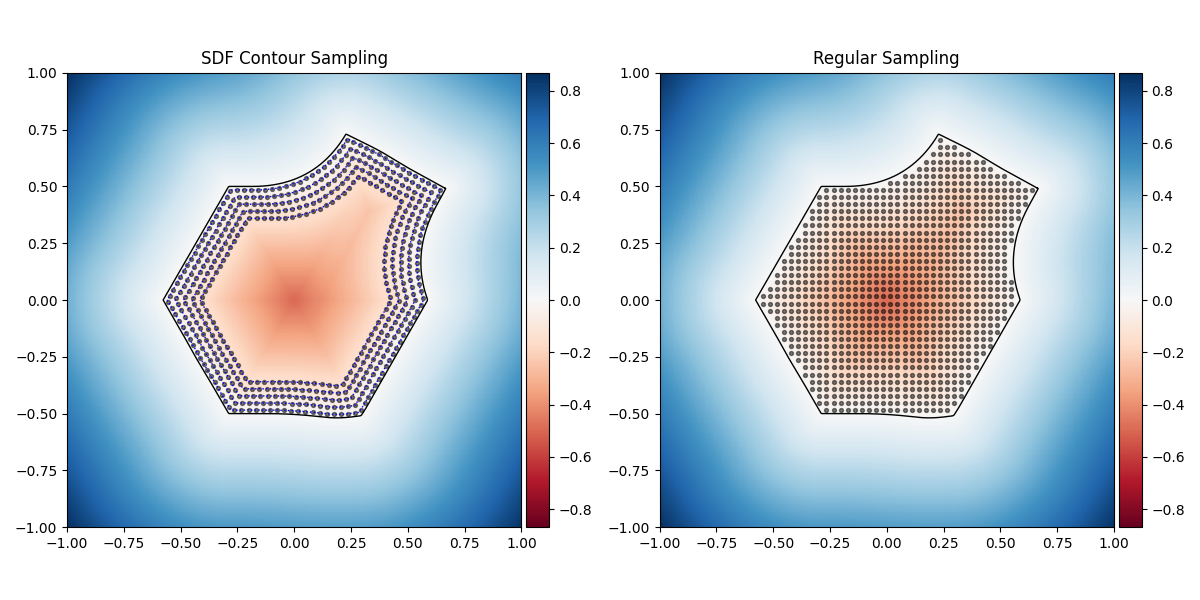

In [88]:
minExtent = -1
maxExtent = 1
nx = 64
dx = (maxExtent - minExtent) / nx
minExtent = torch.tensor([-1.,-1.])
maxExtent = torch.tensor([1.,1.])
nGrid = 511

bands = 4
sampled, points = sampleSDF(sdf, minExtent, maxExtent, nGrid)


internalBands = 5
externalBands = 0
print(internalBands)

fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)
axis[0,0].set_aspect('equal', 'box')
axis[0,0].set_xlim(-1, 1)
axis[0,0].set_ylim(-1, 1)

im = axis[0,0].pcolormesh(points[:,0].reshape(nGrid,nGrid).numpy(), points[:,1].reshape(nGrid,nGrid).numpy(), sampled.numpy(), cmap='RdBu', vmin = -torch.max(torch.abs(sampled)).numpy(), vmax = torch.max(torch.abs(sampled)).numpy())
axis[0,0].set_title("SDF Contour Sampling")
divider = make_axes_locatable(axis[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

for i in range(externalBands):
    contours = find_contour(sampled, minExtent, maxExtent, nGrid, dx/2  + dx * (i))
    for contour in contours:
        axis[0,0].plot(contour[:, 0], contour[:, 1], linewidth=1, color = 'red', ls = '--')
        # newContour = sampleContour(contour, adjustSpacing(contourLength(contours[0]), dx))
        # axis[0,0].scatter(newContour[:,0], newContour[:,1], s = 8, c = 'red')

for i in range(internalBands):
    contours = find_contour(sampled, minExtent, maxExtent, nGrid, -dx/2 - dx * (i))
    for contour in contours:
        axis[0,0].plot(contour[:, 0], contour[:, 1], linewidth=1, color = 'blue', ls = ':')
        newContour = sampleContour(contour, adjustSpacing(contourLength(contours[0]), dx))
        axis[0,0].scatter(newContour[:,0], newContour[:,1], s = 8, c = 'black', alpha = 0.5)

contours = find_contour(sampled, minExtent, maxExtent, nGrid, 0)
for contour in contours:
    axis[0,0].plot(contour[:, 0], contour[:, 1], linewidth=1, color = 'black', ls = '-')
    axis[0,1].plot(contour[:, 0], contour[:, 1], linewidth=1, color = 'black', ls = '-')
    # newContour = sampleContour(contour, adjustSpacing(contourLength(contours[0]), dx))
    # axis[0,0].scatter(newContour[:,0], newContour[:,1], s = 8, c = 'black')


regularParticles = sampleRegular(dx, dim, minExtent, maxExtent, targetNeighbors, True, k)[0]
masked, mask, particle_sdf, *_ = filterParticlesWithSDF(regularParticles, sdf, h, -dx/2 * 0.97)

im = axis[0,1].pcolormesh(points[:,0].reshape(nGrid,nGrid).numpy(), points[:,1].reshape(nGrid,nGrid).numpy(), sampled.numpy(), cmap='RdBu', vmin = -torch.max(torch.abs(sampled)).numpy(), vmax = torch.max(torch.abs(sampled)).numpy())
axis[0,1].set_title("Regular Sampling")
divider = make_axes_locatable(axis[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axis[0,1].set_aspect('equal', 'box')
axis[0,1].set_xlim(-1, 1)
axis[0,1].set_ylim(-1, 1)
im = axis[0,1].scatter(regularParticles[mask,0], regularParticles[mask,1], s = 8, c = 'black', alpha = 0.5)


fig.tight_layout()


In [89]:
from diffSPH.naca import naca4

torch.Size([201, 2])
tensor([[ 1.0000e+00, -1.6653e-17],
        [ 9.9975e-01,  3.5855e-05],
        [ 9.9901e-01,  1.4332e-04],
        [ 9.9778e-01,  3.2207e-04]], dtype=torch.float64) tensor([[ 9.9778e-01, -3.2207e-04],
        [ 9.9901e-01, -1.4332e-04],
        [ 9.9975e-01, -3.5855e-05],
        [ 1.0000e+00,  1.6653e-17]], dtype=torch.float64)
3


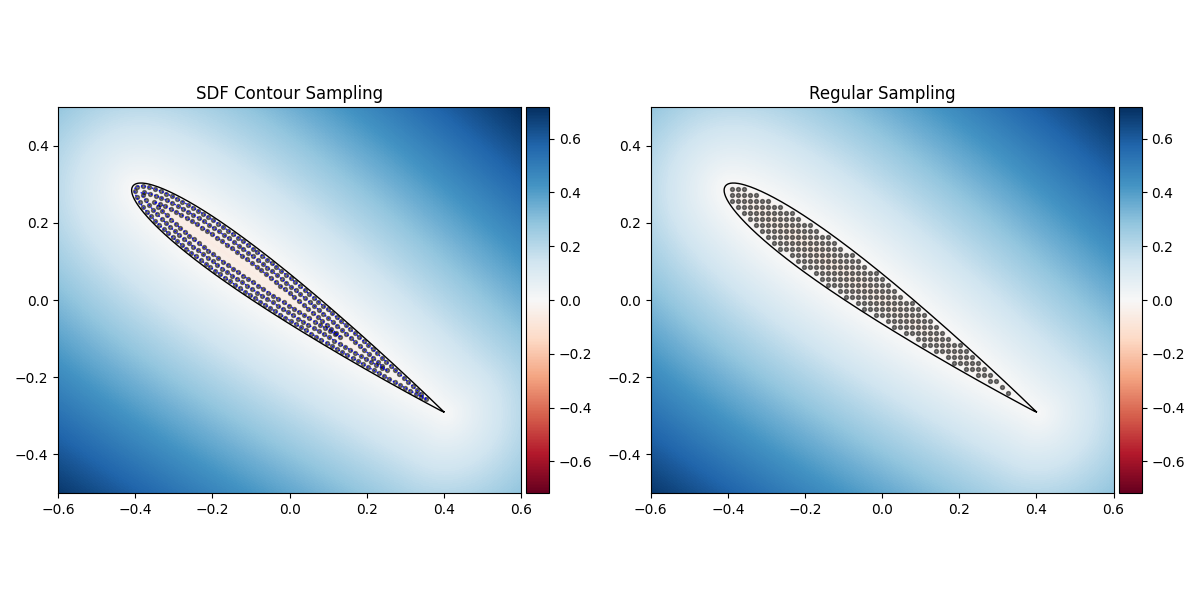

In [129]:
x,y = naca4('0012', 100, half_cosine_spacing = True)

poly = np.stack([np.array(x),np.array(y)]).transpose()
poly = torch.tensor(poly)
print(poly.shape)
print(poly[:4,:], poly[-4:,:])
center = torch.mean(poly, axis = 0)

sdf = operatorDict['rotate'](operatorDict['translate'](operatorDict['invert'](lambda points: getSDF('polygon')['function'](points, poly[:-1,:])), -center),np.pi/5)

# fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)

minExtent = -1
maxExtent = 1
nx = 128
dx = (maxExtent - minExtent) / nx
minExtent = torch.tensor([-0.6,-0.5])
maxExtent = torch.tensor([0.6,0.5])

sampled, points = sampleSDF(sdf, minExtent, maxExtent, nGrid)


internalBands = 3
externalBands = 0
print(internalBands)

fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_aspect('equal', 'box')
axis[0,0].set_xlim(minExtent[0], maxExtent[0])
axis[0,0].set_ylim(minExtent[1], maxExtent[1])

im = axis[0,0].pcolormesh(points[:,0].reshape(nGrid,nGrid).numpy(), points[:,1].reshape(nGrid,nGrid).numpy(), sampled.numpy(), cmap='RdBu', vmin = -torch.max(torch.abs(sampled)).numpy(), vmax = torch.max(torch.abs(sampled)).numpy())
axis[0,0].set_title("SDF Contour Sampling")
divider = make_axes_locatable(axis[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

for i in range(externalBands):
    contours = find_contour(sampled, minExtent, maxExtent, nGrid, dx/2  + dx * (i))
    for contour in contours:
        axis[0,0].plot(contour[:, 0], contour[:, 1], linewidth=1, color = 'red', ls = '--')
        # newContour = sampleContour(contour, adjustSpacing(contourLength(contours[0]), dx))
        # axis[0,0].scatter(newContour[:,0], newContour[:,1], s = 8, c = 'red')

for i in range(internalBands):
    contours = find_contour(sampled, minExtent, maxExtent, nGrid, -dx/2 - dx * (i))
    for contour in contours:
        axis[0,0].plot(contour[:, 0], contour[:, 1], linewidth=1, color = 'blue', ls = ':')
        newContour = sampleContour(contour, adjustSpacing(contourLength(contours[0]), dx))
        axis[0,0].scatter(newContour[:,0], newContour[:,1], s = 8, c = 'black', alpha = 0.5)

contours = find_contour(sampled, minExtent, maxExtent, nGrid, 0)
for contour in contours:
    axis[0,0].plot(contour[:, 0], contour[:, 1], linewidth=1, color = 'black', ls = '-')
    axis[0,1].plot(contour[:, 0], contour[:, 1], linewidth=1, color = 'black', ls = '-')
    # newContour = sampleContour(contour, adjustSpacing(contourLength(contours[0]), dx))
    # axis[0,0].scatter(newContour[:,0], newContour[:,1], s = 8, c = 'black')


regularParticles = sampleRegular(dx, dim, minExtent, maxExtent, targetNeighbors, True, k)[0]
masked, mask, particle_sdf, *_ = filterParticlesWithSDF(regularParticles, sdf, h, -dx/2 * 0.97)

im = axis[0,1].pcolormesh(points[:,0].reshape(nGrid,nGrid).numpy(), points[:,1].reshape(nGrid,nGrid).numpy(), sampled.numpy(), cmap='RdBu', vmin = -torch.max(torch.abs(sampled)).numpy(), vmax = torch.max(torch.abs(sampled)).numpy())
axis[0,1].set_title("Regular Sampling")
divider = make_axes_locatable(axis[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axis[0,1].set_aspect('equal', 'box')
axis[0,1].set_xlim(minExtent[0], maxExtent[0])
axis[0,1].set_ylim(minExtent[1], maxExtent[1])
im = axis[0,1].scatter(regularParticles[mask,0], regularParticles[mask,1], s = 8, c = 'black', alpha = 0.5)


fig.tight_layout()


# axis[0,0].set_aspect('equal', 'box')
# axis[0,0].plot(x,y)
